# Development: Integrate ORCA with Milestone Tracking

In [1]:
import sys
sys.path.append('../')
from panav.environment.env import MultiTunnelEnv,DefaultEmtpyEnv
from panav.hybrid import HybridGraph
from panav.util import flowtime,makespan
from panav.PBS.PBS import PBS
from panav.TrafficAwarePlanning import TAHP
from panav.sequential import sequential_planning
from panav.SAMP.solvers import Tube_Planning



from time import time
import pickle as pkl

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

sys.path.append('../../')
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
from panav.environment.env import NavigationEnv
from panav.environment.region import Box2DRegion, PolygonRegion
from panav.environment.utils import box_2d_center

from panav.viz import draw_env


import shapely

from panav.ORCA import ORCA_Agent
from panav.util import unique_tx

%load_ext autoreload
%autoreload 2

%load_ext snakeviz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:

bloating_r = 0.5
vmax = 1.0

N = 20


results = []

env_name = "MultiTunnel"


# env = MultiTunnelEnv(n_tunnel = 4, tunnel_width = bloating_r*2.5,limits=[(-50,50),(-50,50)], N_agent = N)
env = DefaultEmtpyEnv(limits=[(-10,10),(-10,10)], N_agent = N)
HG = HybridGraph(env,bloating_r)


In [6]:
from panav.TrafficAwarePlanning import traffic_aware_HG_plan
paths = traffic_aware_HG_plan(HG)

ref_plan = [np.array([HG.node_loc(u) for u in path]).T for path in paths]

In [13]:

plans = ref_plan

tau = 1 # The safe time interval. Can be generously long.
exec_tau = 1.0 * tau 
agents = set(np.arange(N))
start_locs = env.starts
goal_locs = env.goals
# The execution time of ORCA velocity.
# Should be much shorter than the safe interval tau.

pos = []

v_prefs = [np.zeros(start_locs[0].shape) for a in agents]

protocol = 0

orcas = [ORCA_Agent(protocol,tau,bloating_r,vmax,p,v) 
         for p,v in zip(start_locs,v_prefs)]

curr_wp_index = [0 for a in agents]

for _ in range(200):
    pos.append(np.array([a.p for a in orcas]))
    
    print("################# Time step {} ################".format(_))   
    # Compute the preferred velocity.
 
    def calc_pref(agent):

        wp = plans[agent][:,curr_wp_index[agent]]
        # See if the agent has reached the current waypoint.
        if np.linalg.norm(wp-orcas[agent].p)<= bloating_r:  
            curr_wp_index[agent] = \
            np.min([curr_wp_index[agent]+1,   
                    plans[agent].shape[1]-1
                                  ])
            
            wp = plans[agent][:,curr_wp_index[agent]]
            
        to_wp = wp-orcas[agent].p
        # print("agent",agent,"to_wp",to_wp,'curr_wp_index',curr_wp_index[agent])
        v_prefs[agent] = to_wp/tau if tau*vmax > np.linalg.norm(to_wp) else vmax *  to_wp/(np.linalg.norm(to_wp)+1e-5)
    
    # opt_worker(delayed(calc_pref)(agent) for agent in agents)
    for agent in agents:
        calc_pref(agent)
    # Update v_opt
    for a in agents:
        orcas[a].update_v_opt(v_prefs[a])
    
    # Compute the safe velocity.
    for a in agents:      
        # print('update v for agent',a)
        orcas[a].update_v(v_prefs[a],env.obstacles,
                        [orcas[b] for b in agents-set([a])])
    
    # Execute the safe velocity.
    all_reached = True
    
    for a in agents:
        dist2goal = np.linalg.norm(orcas[a].p - goal_locs[a])
        print(a,dist2goal)

        if dist2goal>=1*bloating_r:
            v = np.array([0,0]) if orcas[a].v is None else orcas[a].v
            # print(orcas[a].v)
            orcas[a].p += v*exec_tau
            all_reached = False
    if all_reached:
        break

################# Time step 0 ################
0 22.627416997969522
1 20.269785335095786
2 18.30334247286578
3 16.865480854231357
4 16.098462467799852
5 16.098462467799852
6 16.865480854231357
7 18.303342472865776
8 20.269785335095786
9 22.627416997969522
10 22.627416997969522
11 20.269785335095786
12 18.30334247286578
13 16.865480854231357
14 16.098462467799852
15 16.098462467799852
16 16.865480854231357
17 18.303342472865776
18 20.269785335095786
19 22.627416997969522
################# Time step 1 ################
0 21.853590135300177
1 19.40876758421517
2 17.350536812122474
3 15.865481447158068
4 15.0984630889768
5 15.0984630889768
6 15.865481447158066
7 17.350536812122467
8 19.4087675842151
9 21.853590135303786
10 21.85359013529982
11 19.40876758421737
12 17.35053681212247
13 15.865481447158068
14 15.0984630889768
15 15.0984630889768
16 15.865481447158066
17 17.35053681212247
18 19.408767584217095
19 21.853590135316033
################# Time step 2 ################
0 21.12053696360

/Users/tianpengzhang/Dropbox (Harvard University)/Tianpeng's research/Tianpeng & Lina/Multiagent Motion Planning/PA-Nav/notebooks_playground/../panav/ORCA.py:280: RuntimeWarning: invalid value encountered in arcsin
  self.phi = np.arcsin(self.r/la.norm(self.center))


0 19.796341647644873
1 17.125959799228852
2 14.817409532850174
3 13.052297071222185
4 12.104414185733255
5 12.104414185733248
6 13.052297071222393
7 14.817409532975505
8 17.12595979922074
9 19.796341647887044
10 19.79634164753705
11 17.125959799233346
12 14.81740953316353
13 13.052297071222519
14 12.104414185733257
15 12.104414185733214
16 13.05229707122261
17 14.817409532613834
18 17.125959799234575
19 19.796341648169616
################# Time step 5 ################
0 19.22184975307011
1 16.520100482926082
2 14.138527938303087
3 12.211493466342024
4 12.104414185733255
5 12.104414185733248
6 12.211493466341004
7 14.138527938499314
8 16.52010048285035
9 19.221849753469563
10 19.221849752987456
11 16.52010048274559
12 14.138527938816578
13 12.211493466306143
14 12.104414185733257
15 12.104414185733214
16 12.211493466309152
17 14.138527937934333
18 16.520100483052452
19 19.221849753931544
################# Time step 6 ################
0 18.71584141641616
1 16.006560074642014
2 13.5646280

/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


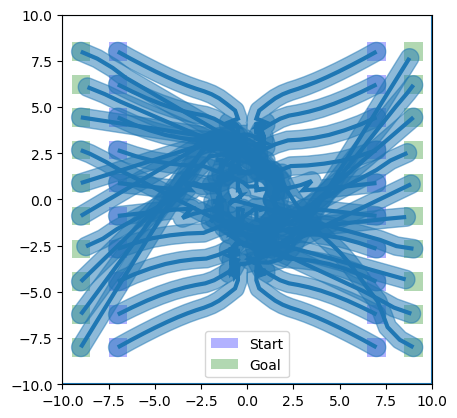

In [14]:

from shapely.plotting import plot_polygon, plot_line
pos = np.array(pos)

ax = plt.gca()
draw_env(env,[],ax)

for a in agents:
    line = shapely.geometry.LineString(pos[:,a,:])
    dilated = line.buffer(bloating_r)

    plot_line(line, ax=ax, add_points=False, linewidth=3)
    plot_polygon(dilated, ax=ax, add_points=False, alpha=0.5)

In [15]:
from panav.viz import animation
from IPython.display import HTML, display

dt = exec_tau

pos_to_ani = [pos[:,a,:].T for a in agents]
anim = animation(env, pos_to_ani, bloating_r, dt = dt)
display(HTML(anim.to_jshtml()))
plt.close() 